In [5]:
import os
import sys
import numpy as np
from ete3 import Tree
import Bio.Phylo as Phylo
import jax
import jax.numpy as jnp
from tqdm import tqdm 
import pandas as pd
import wandb
#import argparse
import scipy
import pickle 
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.backends.backend_pdf as backend_pdf


from bridge_sampling.BFFG import backward_filter, forward_guide, forward_guide_edge, get_logpsi
from bridge_sampling.setup_SDEs import Stratonovich_to_Ito, dtsdWsT, dWs
from bridge_sampling.noise_kernel import Q12
from bridge_sampling.helper_functions import *

from mcmc import *

In [6]:
n = 20
d = 2

# load tree 
leaves = jnp.array(pd.read_csv('comparison/seed=10_sigma=0.5_alpha=0.05_dt=0.1/leaves.csv', delimiter=',', header=0, index_col=0))#np.genfromtxt('comparison/seed=10_sigma=0.5_alpha=0.05_dt=0.1/leaves.csv', delimiter=','))
tree = Tree("data/chazot_subtree_rounded.nw")
print(leaves.shape)

# choose super root
vcv = get_tree_covariance("data/chazot_subtree_rounded.nw")
print(vcv)
#vcv = np.genfromtxt(datapath + '/phylogeny_vcv.csv', delimiter=' ')
#super_root = 1/(np.ones(leaves.shape[0]).T@np.linalg.inv(vcv)@np.ones(leaves.shape[0]))*np.ones(leaves.shape[0]).T@np.linalg.inv(vcv)@leaves
# Step 1: Solve the linear system vcv @ x = ones
w = np.linalg.solve(vcv, np.ones(leaves.shape[0])) 
# Step 2: Normalize the weights
w_norm = w / np.sum(w)
# Step 3: Compute weighted average of leaves
super_root = w_norm.T @ leaves

# define prior and proposal distributions  
proposal_sigma = MirroredGaussian(tau=0.001, minval=0, maxval=10)
proposal_alpha = MirroredGaussian(tau=0.001, minval=0, maxval=10)
prior_sigma = Uniform(minval=0.7, maxval=1.3)
prior_alpha = Uniform(minval=0.0005, maxval=0.03)

# define stochastic process 
# define drift and diffusion for process of interest 
sti=1
if sti ==1:
    b,sigma,_ = Stratonovich_to_Ito(lambda t,x,theta: jnp.zeros(n*d),
                                lambda t,x,theta: Q12(x,theta))
else:
    b = lambda t,x,theta: jnp.zeros(n*d)
    sigma = lambda t,x,theta: Q12(x,theta)
    

# MCMC settings
burnin_percent = 0.2
seed = np.random.randint(0, 1000000)
outputpath = "mcmc_test"


(5, 40)
[[7.6 3.5 0.  0.  0. ]
 [3.5 7.6 0.  0.  0. ]
 [0.  0.  7.6 1.7 1.7]
 [0.  0.  1.7 7.6 3.4]
 [0.  0.  1.7 3.4 7.6]]


In [7]:
results = metropolis_hastings(
    N=5,
    dt=0.1, # should pick the same as used in the simulation
    lambd=0.95,
    obs_var=0.001,
    rb=1.0,
    xs=super_root,
    drift_term=b, 
    diffusion_term=sigma,
    prior_sigma=prior_sigma,
    prior_alpha=prior_alpha,
    proposal_sigma=proposal_sigma,
    proposal_alpha=proposal_alpha,
    tree=tree,
    leaves = leaves,
    n=n, 
    d=d,
    outputpath=outputpath,
    seed_mcmc = seed,
    use_wandb=False,
    wandb_project="SPMS_MCMC")

100%|██████████| 5/5 [00:10<00:00,  2.04s/it]


## Look at results

Acceptance rate paths 0.5


Text(0.5, 1.0, 'Log posterior')

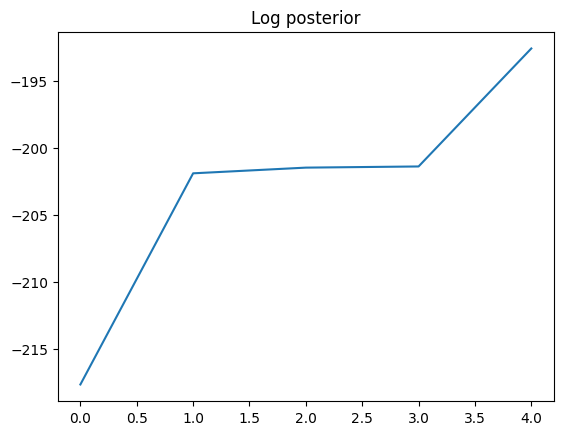

In [8]:
print(f"Acceptance rate paths {np.mean(results['acceptpath'])}")
plt.plot(results['log_posterior'])
plt.title("Log posterior")

Text(0.5, 1.0, 'Alpha trace')

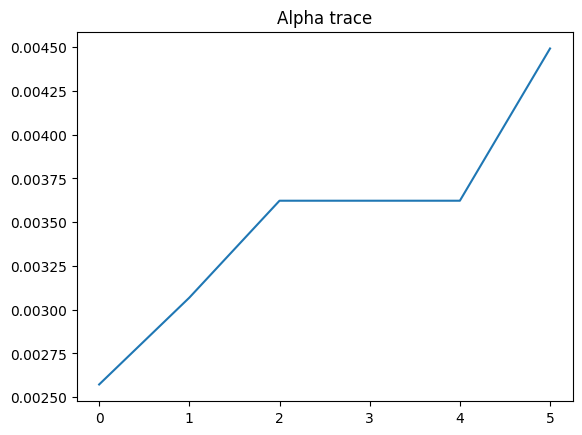

In [9]:
plt.plot(results['alphas'])
plt.title("Alpha trace")

Text(0.5, 1.0, 'Sigma trace')

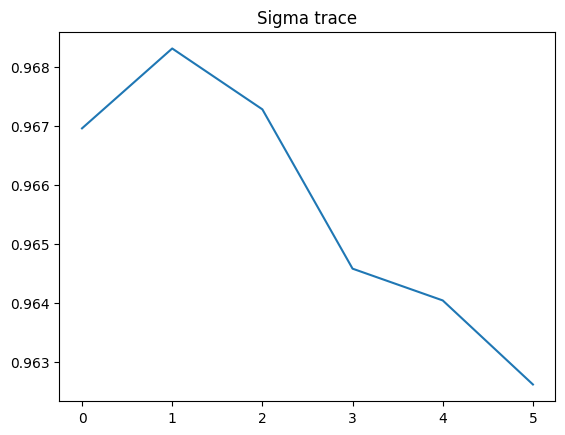

In [10]:
plt.plot(results['sigmas'])
plt.title("Sigma trace")


In [11]:
# Traces for all inner nodes 

# expand according to tree counter + remove burnin percent 
trees = results['trees']
tree_counter = results['tree_counter']
print(trees.shape)
tree_counter

# plot trace for each dimension in each inner node 
expanded_trees = expand_mcmc_samples(trees, tree_counter)
print(f"Original shape: {trees.shape}, Expanded shape: {expanded_trees.shape}")

# Apply burnin if needed
burnin_idx = int(len(expanded_trees) * burnin_percent)
trees_after_burnin = expanded_trees[burnin_idx:]
trees_after_burnin.shape

# read inner nodes from file
true_tree = np.genfromtxt('comparison/seed=10_sigma=0.5_alpha=0.05_dt=0.1/flat_true_tree.csv', delimiter=',')
print(true_tree.shape)
#true_innernode = innernode[burnin_idx:]
#true_innernode.shape


(16, 9, 40)
Original shape: (16, 9, 40), Expanded shape: (16, 9, 40)
(9, 40)


In [12]:
### obs! wrap this into a function + be able to handle several chains 

# Make sure path exists
os.makedirs(os.path.dirname(f"{outputpath}/trace_burnin={burnin_percent}.pdf"), exist_ok=True)

# Create PDF
with PdfPages(f"{outputpath}/trace_burnin={burnin_percent}.pdf") as pdf:
    for idx in range(trees_after_burnin.shape[1]): #loop over all nodes 
        # Create a new figure for each node
        fig, axes = plt.subplots(nrows=7, ncols=6, figsize=(25,15), sharex=True)
        node = trees_after_burnin[:,idx, :]
        
        # Add a proper suptitle to the figure (this is the main title)
        fig.suptitle(f"Trace for Node {idx}", fontsize=16)
        
        # Plot each dimension
        for i, ax in zip(range(node.shape[1]), axes.flat):
            ax.plot(node[:,i], alpha=0.5)
            ax.set_title(f"Landmark {idx}, Dimension {i}")
            ax.hlines(y=true_tree[idx][i], xmin=0, xmax=node.shape[0], color='orange')
        
        # Adjust layout to make room for the title
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        
        # Save the current figure to PDF and close it
        pdf.savefig(fig)
        plt.close(fig)

print(f"PDF saved to {outputpath}/trace_burnin={burnin_percent}.pdf")

PDF saved to mcmc_test/trace_burnin=0.2.pdf


# Run several chains in parallel and get diagnostics